<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#FUNCTIONS---Run-at-start" data-toc-modified-id="FUNCTIONS---Run-at-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>FUNCTIONS - Run at start</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Filter" data-toc-modified-id="Filter-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Filter</a></span></li><li><span><a href="#Classify" data-toc-modified-id="Classify-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Classify</a></span></li></ul></li><li><span><a href="#Setup-und-Algo" data-toc-modified-id="Setup-und-Algo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup und Algo</a></span><ul class="toc-item"><li><span><a href="#Multiprocessing" data-toc-modified-id="Multiprocessing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Multiprocessing</a></span></li></ul></li><li><span><a href="#Analysis-of-resulting-classifications" data-toc-modified-id="Analysis-of-resulting-classifications-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis of resulting classifications</a></span><ul class="toc-item"><li><span><a href="#Error-volatility" data-toc-modified-id="Error-volatility-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Error volatility</a></span></li><li><span><a href="#Distribution-of-classes-per-classification-technique" data-toc-modified-id="Distribution-of-classes-per-classification-technique-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Distribution of classes per classification technique</a></span></li><li><span><a href="#Transition-tables" data-toc-modified-id="Transition-tables-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Transition tables</a></span></li><li><span><a href="#Comparing-mean-return-per-class-for-the-different-classification-techniques" data-toc-modified-id="Comparing-mean-return-per-class-for-the-different-classification-techniques-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Comparing mean return per class for the different classification techniques</a></span></li></ul></li><li><span><a href="#Sanity-checks" data-toc-modified-id="Sanity-checks-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Sanity checks</a></span><ul class="toc-item"><li><span><a href="#Analysing-individual-portfolios" data-toc-modified-id="Analysing-individual-portfolios-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Analysing individual portfolios</a></span></li><li><span><a href="#Inspecting-individual-nearest-neighbors" data-toc-modified-id="Inspecting-individual-nearest-neighbors-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Inspecting individual nearest neighbors</a></span></li><li><span><a href="#Tests" data-toc-modified-id="Tests-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Tests</a></span></li></ul></li></ul></div>

# Classification

In [1]:
import feather
import numpy as np
import pandas as pd
from scipy import sparse

import seaborn as sns
import matplotlib.pyplot as plt

from multiprocessing import Pool
from itertools import product

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

# Progress bar
from ipywidgets import FloatProgress
from IPython.display import display

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import logging
logging.basicConfig(level=logging.DEBUG, format='%(levelname)s - %(message)s')

DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## FUNCTIONS - Run at start

### Load Data

In [2]:
### Returns
path = '../data/processed/returns.feather'
returns = feather.read_dataframe(path)
returns = returns.rename(columns = {'caldt' : 'report_dt'})
returns = returns.assign(year = returns['report_dt'].dt.year)

### row_info
path = '../data/processed/row_info.feather'
row_info = feather.read_dataframe(path)

### col_info
path = '../data/processed/col_info.feather'
col_info = feather.read_dataframe(path)

### Holdings
path = '../data/processed/holdings.npz'
holdings = sparse.load_npz(path)

### Filter

In [103]:
def filter_data(param, verbose = False):
    year = param.loc[0,'year']
    if param.loc[0,'preprocessing'] == 1:
        preprocessing = 'l1'
    if param.loc[0,'preprocessing'] == 2:
        preprocessing = 'l2'
        
    row_info_f = row_info.copy()
    if (year != 'full'):    # If year = full take whole sample
        row_info_f = row_info_f.query('year == @year')

    begin_date = row_info_f.iloc[0,:]['report_dt']
    end_date = begin_date + pd.DateOffset(years=1) # 1 year offset
    row_info_f.reset_index(drop = True, inplace=True)

    # Filter returns
    crsp_fundno_unique = row_info_f['crsp_fundno'].unique()
    returns_f = returns.copy()
    query = '''report_dt >= @begin_date and report_dt <= @end_date and crsp_fundno in @crsp_fundno_unique'''
    returns_f = returns_f.query(query)

    # Change return of month for which holdings apply to 0
    returns_f = returns_f.copy()
    mask = returns_f['report_dt'] == begin_date
    returns_f.loc[mask,'mret'] = 0
    
    # Drop all funds with first return observation after starting date
    drop_fundnos = returns_f.drop_duplicates('crsp_fundno').query('mret != 0')['crsp_fundno']
    returns_f.query('crsp_fundno not in @drop_fundnos', inplace=True)
    row_info_f.query('crsp_fundno not in @drop_fundnos', inplace=True)
    
    # Filter holdings accordingly and delet all securities with less than two observations
    holdings_f = holdings.copy()
    holdings_f = holdings[row_info_f['row']]
    
    holdings_b = sparse.csr_matrix(holdings_f, copy=True)
    holdings_b.data = np.ones(len(holdings_f.data))

    sum_sec_boolean = holdings_b.toarray().sum(0)
    col_mask = (sum_sec_boolean >= 2).flatten()

    holdings_f = holdings_f.tocsc()
    holdings_f = holdings_f[:,col_mask]
    holdings_f = holdings_f.tocsr()
    
    ## Preprocessing
    if (preprocessing == 'none'): holdings_ft = holdings_f
    if (preprocessing == 'l1'):   holdings_ft = normalize(holdings_f, norm = 'l1')
    if (preprocessing == 'l2'):   holdings_ft = normalize(holdings_f, norm = 'l2')
    
    if (verbose):
        print('Numer of unique funds:           {:10,d}'.format(row_info_f.shape[0]))
        print('Numer of unique securities:      {:10,d}'.format(holdings_ft.shape[1]))
        print('Begin date:                      {}'.format(begin_date.date()))
        print('End date:                        {}'.format(end_date.date()))
    
    return(row_info_f, returns_f, holdings_ft, begin_date, end_date)

### Classify

In [104]:
def classify(row_info_f, holdings_f, param, verbose=False):
    np.random.seed()
    
    if param.loc[0,'weights'] == 1:
        weights = 'distance'
    if param.loc[0,'weights'] == 2:
        weights = 'uniform'

    if param.loc[0,'preprocessing'] == 1:
        preprocessing = 'l1'
    if param.loc[0,'preprocessing'] == 2:
        preprocessing = 'l2'
        
    #### Setup ####
    # Classifier
    neigh = KNeighborsClassifier(n_neighbors = param.loc[0,'n_neighbors'].astype(int), 
                                 p           = param.loc[0,'distance_param'].astype(int), 
                                 #metric      = 'hamming'
                                 weights     = weights, 
                                 n_jobs      = 1) # distance or uniform
    
    # Data
    X = holdings_f
    y = row_info_f['lipper_class'].values
    n_rows = holdings_f.shape[0]

    # Result dataframe
    style_df = pd.DataFrame({'model_lipper' : y})

    #### Full #### 
    # Predict all at once and save in style_df
    loo = LeaveOneOut()
    loo.get_n_splits(X)

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        neigh.fit(X_train,y_train)
        style_df.loc[test_index, 'model_knn_loo'] = neigh.predict(X_test)

    #### Iterative ####
    style_df['model_knn_iterative'] = style_df['model_lipper']
    
    # Index : Setup of index for choosing rows iteratively
    index = np.arange(n_rows)
    np.random.shuffle(index)
    index = np.concatenate((index,index,index,index,index))
    
    n_rows_chosen = round(n_rows * param.loc[0,'perc_rows_used']).astype(int)
    index = index[:n_rows_chosen]
    it = iter(index)
    index = zip(it)
    chosen_indices = []

    # Loop over n_iterations, choose one observation randomly, predict label, save and repeat
    f = FloatProgress(min=0, max=n_rows_chosen)
    if(verbose): 
        display(f)

    for i in index:
        mask = np.arange(X.shape[0]) # mask for whole sample
        mask_is = ~np.isin(mask,i)   # mask to choose all in sample observations
        mask_oos = np.isin(mask,i)   # mask to choose the x out of sample observations for which we predict
        chosen_indices.append(i)

        # Mask X and labels to exclude row for which prediction will be made
        X_sub = X[mask_is]
        y_sub = style_df.loc[mask_is,'model_knn_iterative'].values

        # Fit knn model on all but randomly chosen row
        neigh.fit(X_sub,y_sub) 

        # Predict and save label for randomly chosen row
        style_df.loc[mask_oos,'model_knn_iterative'] = neigh.predict(X[mask_oos])
        f.value += 2

    row_chosen = np.unique(np.array(chosen_indices).flatten()).shape[0]
    #print('Rows randomly chosen:    {:4.2f}%'.format(row_chosen / X.shape[0] * 100))
    #print('Done')
    
    return(style_df)

In [105]:
def calc_styleadj_returns(row_info_f,returns_f,style_df):

    row_info_m = row_info_f.copy()
    returns_m = returns_f.copy()

    # concat predicted styles to row_info
    row_info_m = pd.concat([row_info_m,style_df],axis = 1)

    # merge predicted styles onto returns
    returns_m = returns_m.merge(row_info_m[[
                                    'crsp_fundno', 'report_dt', 'model_lipper', 'model_knn_loo',
                                    'model_knn_iterative'
                                    ]],
                                    how='left',
                                    on=['crsp_fundno', 'report_dt'])

    # melt the different style columns per model into one (from wide to long)
    returns_m = pd.melt(returns_m,
                                   id_vars=['crsp_fundno', 'report_dt', 'mret'],
                                   value_vars=cols,
                                   var_name='model',
                                   value_name='style')

    # Fill all styles and drop nas

    temp = (returns_m
                                    .groupby(['model','crsp_fundno'])
                                    .apply(lambda x: x.fillna(method = 'ffill'))
    )

    returns_m['style'] = temp['style']
    returns_m = returns_m.dropna()

    # Calc mean return per style
    style_returns = (returns_m
                                    .groupby(['model','style','report_dt'])
                                    .mean()
                                    .reset_index()
                                    .drop(columns='crsp_fundno')
    )

    # Calc cumret per style
    style_returns['cum_ret'] = (style_returns
                                    .assign(cum_ret = lambda x: x.mret + 1)
                                    .groupby(['model','style'])
                                    .apply(lambda x: x['cum_ret'].cumprod())
                                    .reset_index()
                                    ['cum_ret']
    )

    # Merge style returns onto fund returns and calc tracking error
    returns_m = (returns_m
                                    .rename(columns = {'mret' : 'fund_ret'}) 
                                    .merge(style_returns,
                                                how = 'left',
                                                on = ['model','style','report_dt'])
                                    .assign(error = lambda df: df['fund_ret'] - df['mret'])
                                    .rename(columns = {'mret' : 'style_ret',
                                                       'cum_ret' : 'style_cum'}) 
    )

    returns_m = returns_m[['crsp_fundno', 'report_dt', 'model', 'style',
                           'fund_ret', 'style_ret', 'style_cum', 'error']]
    
    return(returns_m, style_returns)

In [106]:
def error_vola_deciles(returns_m): 
    error_vol = (returns_m
                 .groupby(['crsp_fundno','model'])['error']
                 .std()
                 .reset_index())
    error_vol['error'] = error_vol['error'] * 100
    
    error_vol = (error_vol
                .groupby('model')[['error']]
                .apply(lambda x : x.quantile(np.round(np.arange(0.1,1,0.1),2)))
                .reset_index()
                .pivot(columns='level_1',values='error',index='model'))
    return(error_vol)

In [126]:
def weighted_average_score_new(param_grid, relevant_params, measures):

    param_grid.reset_index()
    param_grid = param_grid.fillna(value=0)
    param_grid['param_id'] = (param_grid
                                  .groupby(relevant_params)
                                  .ngroup())
    
    # Fix for issue with same param_id for lipper rows
    lipper_rows = param_grid.loc[param_grid['model'] == 'lipper',:].copy()
    lipper_rows['param_id'] = lipper_rows.groupby(['preprocessing']).ngroup()
    lipper_rows['param_id'] = (lipper_rows['param_id'] + 1) * -1
    param_grid.loc[param_grid['model'] == 'lipper'] = lipper_rows

    scores = param_grid[measures]
    params_only = param_grid.drop(columns = measures)
    
    weights = (param_grid[['year','count']]
                                  .drop_duplicates()
                                  .assign(weight = lambda x: x['count'] / np.sum(x['count'])))
    weights = weights[['weight']].values

    scores = scores.groupby(params_only['param_id']).apply(lambda x: np.sum(x * weights))

    params_only = (params_only
                      .drop_duplicates(relevant_params)
                      .drop(columns = ['year','count']))

    result = params_only.merge(scores, how = 'left', on = 'param_id')
    
    return(result)

In [127]:
def weighted_average_score(results): 
    deciles = results.iloc[:,0:9]
    deciles = deciles.reset_index(drop = True)

    param_grid = results.iloc[:,9:]
    param_grid = param_grid.reset_index()

    weights = (param_grid[['year','count']]
                                  .drop_duplicates()
                                  .assign(weight = lambda x: x['count'] / np.sum(x['count'])))
    weights = weights[['weight']].values

    param_grid['param_id'] = (param_grid
                                  .groupby(['model','perc_rows_used', 'distance_param', 'n_neighbors', 'weights'])
                                  .ngroup())
    
    deciles = deciles.groupby(param_grid['param_id']).apply(lambda x: np.sum(x * weights))


    param_grid = (param_grid
                      .drop_duplicates(['model','perc_rows_used', 'distance_param', 'n_neighbors', 'weights'])
                      .drop(columns = ['year','count']))

    result = param_grid.merge(deciles, how = 'left', on = 'param_id')
    
    return(result)

In [128]:
weighted_average_score_new(results, 
                           relevant_params = ['model','perc_rows_used', 'distance_param', 
                                                       'n_neighbors', 'weights'], 
                           measures = np.arange(0.1,1,0.1))

KeyError: 'model'

In [108]:
def full_algo(year,perc_rows_used,distance_param,n_neighbors,weights,preprocessing):
        
    param = pd.DataFrame(np.array([[year, perc_rows_used, distance_param, n_neighbors, weights, preprocessing]]),
                   columns = ['year','perc_rows_used','distance_param','n_neighbors', 'weights', 'preprocessing'])
    
    if param.loc[0,'weights'] == 1:
        weights = 'distance'
    if param.loc[0,'weights'] == 2:
        weights = 'uniform'
        
    if param.loc[0,'preprocessing'] == 1:
        preprocessing = 'l1'
    if param.loc[0,'preprocessing'] == 2:
        preprocessing = 'l2'
    
    np.random.seed(0)
    
    row_info_f, returns_f, holdings_f, begin_date, end_date = filter_data(param)
    logging.debug('Data loaded and filtered')
    
    style_df = classify(row_info_f, holdings_f, param, verbose=False)
    logging.debug('Classification complete')
    
    returns_m, style_returns = calc_styleadj_returns(row_info_f, returns_f, style_df)
    logging.debug('Style calculated')
    
    temp = error_vola_deciles(returns_m)
    logging.debug('Deciles calculated')
    logging.info('Algo completed')
    
    temp['year']           = param.loc[0,'year']
    temp['count']          = row_info_f.shape[0]
    temp['perc_rows_used'] = param.loc[0,'perc_rows_used']
    temp['distance_param'] = param.loc[0,'distance_param']
    temp['n_neighbors']    = param.loc[0,'n_neighbors']
    temp['weights']        = weights
    temp['preprocessing']  = preprocessing
    
    return(temp)

In [109]:
def expand_grid(dictionary):
    temp = pd.DataFrame([row for row in product(*dictionary.values())], 
                           columns=dictionary.keys())
    return(temp)

## Setup und Algo

In [110]:
#### Options #####
##################
style_class      = 'lipper_class' # Choose lipper_class, style_class or cap_class
cols             = ['model_lipper',
                    'model_knn_loo',
                    'model_knn_iterative'] # Do not change, only names

In [111]:
full = [2010,2011,2012,2013,2014,2015]
param_grid = dict(year           = [2010,2011,2012], # Integer or string 'full' for the whole sample
                  perc_rows_used = [1,2,3],         # 1: all funds are reclassified once, 2: ... twice, etc.
                  distance_param = [1],       # 1: manhattan distance, 2: euclidian distance
                  n_neighbors    = [10],        # Number of neighbors to use in k-nn algorithm
                  weights        = [1],          # One of 1: (distance) or 2: (uniform)
                  preprocessing  = [1,2]       # One of 'l1', 'l2', 'none'
                 )

param_grid = expand_grid(param_grid)
param_tuples = list(param_grid.itertuples(index=False,name=None))

print('Number of iterations:       {}'.format(param_grid.shape[0]))

Number of iterations:       18


### Multiprocessing

In [112]:
with Pool() as pool:
    results = pool.starmap(full_algo, param_tuples)
results = pd.concat(results)
print('Finished')

DEBUG - Data loaded and filtered
DEBUG - Data loaded and filtered
DEBUG - Data loaded and filtered
DEBUG - Data loaded and filtered
DEBUG - Data loaded and filtered
DEBUG - Data loaded and filtered
DEBUG - Data loaded and filtered
DEBUG - Data loaded and filtered
DEBUG - Classification complete
DEBUG - Classification complete
DEBUG - Classification complete
DEBUG - Classification complete
DEBUG - Style calculated
DEBUG - Deciles calculated
INFO - Algo completed
DEBUG - Style calculated
DEBUG - Deciles calculated
INFO - Algo completed
DEBUG - Data loaded and filtered
DEBUG - Data loaded and filtered
DEBUG - Style calculated
DEBUG - Deciles calculated
INFO - Algo completed
DEBUG - Style calculated
DEBUG - Deciles calculated
INFO - Algo completed
DEBUG - Data loaded and filtered
DEBUG - Data loaded and filtered
DEBUG - Classification complete
DEBUG - Classification complete
DEBUG - Style calculated
DEBUG - Deciles calculated
INFO - Algo completed
DEBUG - Style calculated
DEBUG - Deciles c

Finished


In [117]:
results

level_1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,year,count,perc_rows_used,distance_param,n_neighbors,weights,preprocessing
model,,,,,,,,,,,,,,,,
model_knn_iterative,0.501384,0.634114,0.725672,0.821929,0.915135,1.051571,1.224606,1.442034,1.825681,2010,2142,1,1,10,distance,l1
model_knn_loo,0.503226,0.632200,0.722333,0.817809,0.922536,1.053334,1.226920,1.446372,1.826745,2010,2142,1,1,10,distance,l1
model_lipper,0.497942,0.617739,0.704685,0.816767,0.925132,1.053093,1.228932,1.450010,1.821210,2010,2142,1,1,10,distance,l1
model_knn_iterative,0.586974,0.712447,0.854500,0.955169,1.087066,1.229457,1.394247,1.627839,1.991977,2010,2142,1,1,10,distance,l2
model_knn_loo,0.558130,0.682759,0.807597,0.909199,1.027029,1.174822,1.339719,1.575141,1.968451,2010,2142,1,1,10,distance,l2
model_lipper,0.497942,0.617739,0.704685,0.816767,0.925132,1.053093,1.228932,1.450010,1.821210,2010,2142,1,1,10,distance,l2
model_knn_iterative,0.498054,0.634909,0.727560,0.815824,0.932148,1.063402,1.230140,1.438399,1.827051,2010,2142,2,1,10,distance,l1
model_knn_loo,0.503226,0.632200,0.722333,0.817809,0.922536,1.053334,1.226920,1.446372,1.826745,2010,2142,2,1,10,distance,l1
model_lipper,0.497942,0.617739,0.704685,0.816767,0.925132,1.053093,1.228932,1.450010,1.821210,2010,2142,2,1,10,distance,l1


In [114]:
data = weighted_average_score(results).sort_values(0.5).drop(columns='param_id')
data_graph = data.query('''distance_param == 2 and weights == 'distance' ''')

ValueError: Unable to coerce to DataFrame, shape must be (6, 9): given (3, 1)

In [ ]:
data.drop_duplicates(['model',0.5])

In [ ]:
sns.lineplot(data = data, y = 0.5, x = 'n_neighbors', hue = 'model')

## Analysis of resulting classifications

### Error volatility

In [216]:
full = [2010,2011,2012,2013,2014,2015,2016]
param_grid = dict(year           = [2017],     # Integer or string 'full' for the whole sample
                  perc_rows_used = [3],          # 1: all funds are reclassified once, 2: ... twice, etc.
                  distance_param = [1],          # 1: manhattan distance, 2: euclidian distance
                  n_neighbors    = [10],         # Number of neighbors to use in k-nn algorithm
                  weights        = [1]         # One or 1 (distance) or 2 (uniform)
                 )

param = expand_grid(param_grid)

In [217]:
row_info_f, returns_f, holdings_f, begin_date, end_date = filter_data(param)

style_df = classify(row_info_f, holdings_f, param, verbose=False)

returns_m, style_returns = calc_styleadj_returns(row_info_f, returns_f, style_df)

temp = error_vola_deciles(returns_m)

In [218]:
error_vol = (returns_m
                 .groupby(['crsp_fundno','model'])['error']
                 .std()
                 .reset_index())

error_vol['error'] = error_vol['error'] * 100
error_vol.groupby('model')['error'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
model_knn_iterative,1815.0,1.014793,1.355245,0.221806,0.651870,0.861590,1.177209,52.988712
model_knn_loo,1815.0,0.991974,1.351045,0.118722,0.636143,0.846746,1.138187,52.990236
model_lipper,1815.0,0.977760,1.340200,0.135575,0.626720,0.834806,1.107804,52.564800


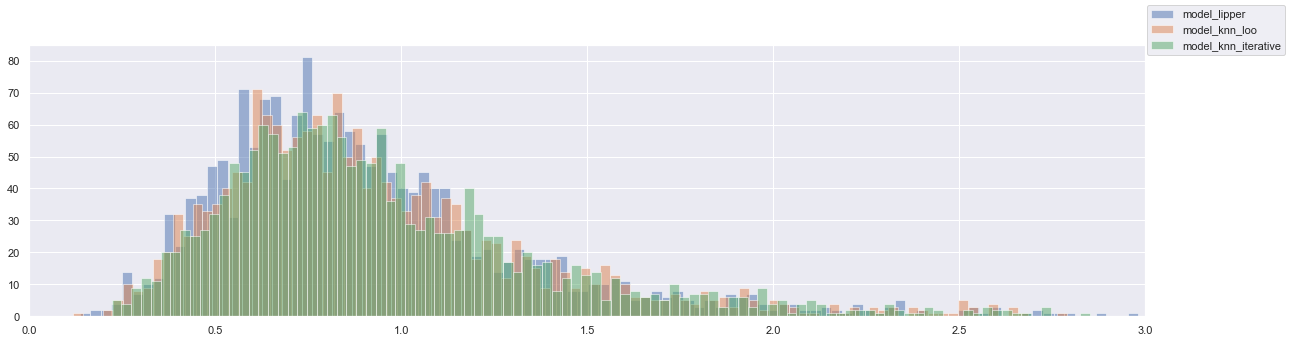

In [219]:
fig, ax = plt.subplots(figsize=(20,5))
for i, col in enumerate(cols):
    ax = error_vol.query(''' model == @col and error < 3''')['error'].hist(label = col,bins = 100, alpha = 0.5)

ax.set_xlim(0,3)    
fig.legend()
plt.show()

### Distribution of classes per classification technique

Overlap between Lipper class and: 

Knn full prediction:         68.00%
Knn iterative prediction:    64.54%


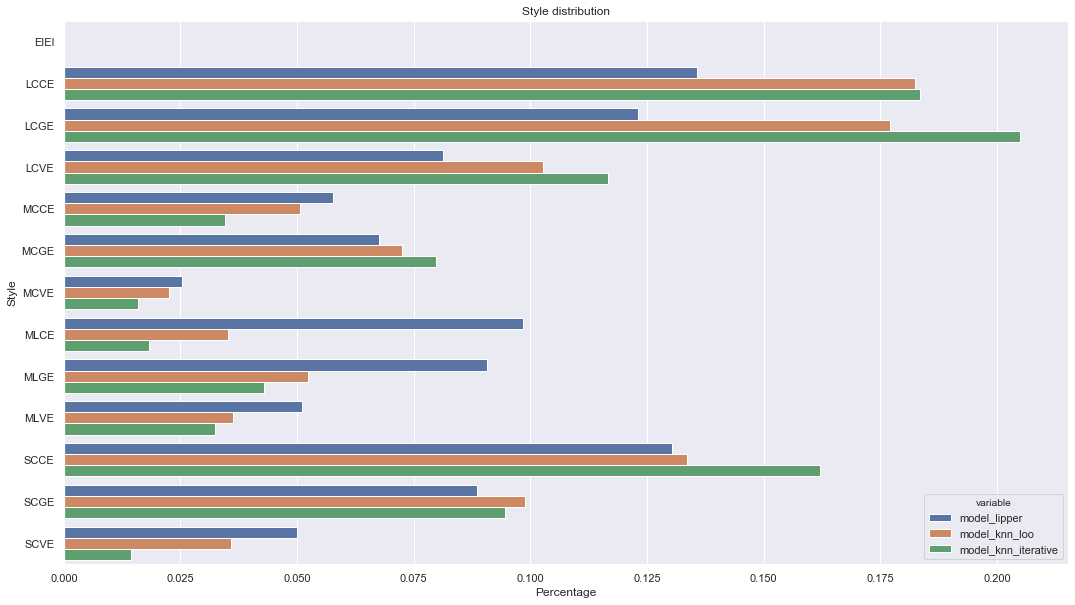

In [220]:
print('Overlap between Lipper class and: \n')
print('Knn full prediction:         {:2.2f}%'
      .format(np.sum(style_df['model_lipper'] == style_df['model_knn_loo']) / len(style_df.index) * 100))
print('Knn iterative prediction:    {:2.2f}%'
      .format(np.sum(style_df['model_lipper'] == style_df['model_knn_iterative']) / len(style_df.index) * 100))

data = style_df.apply(pd.Series.value_counts, normalize = True)
data = data.assign(style = data.index)
data = data.melt(id_vars = 'style', value_vars = data.columns[:-1])

sns.set()
plt.figure(figsize=(18,10))
g = sns.barplot(data = data, y = 'style', x = 'value', hue = 'variable')

plt.title('Style distribution')
plt.ylabel('Style')
plt.xlabel('Percentage')

plt.show()

### Transition tables

In [205]:
round(pd.crosstab(style_df['model_lipper'], style_df['model_knn_iterative'], margins=True, normalize='all') * 100,1)

model_knn_iterative,LCVE,LCCE,LCGE,MLVE,MLCE,MLGE,MCVE,MCCE,MCGE,SCVE,SCCE,SCGE,All
model_lipper,,,,,,,,,,,,,
LCVE,7.0,0.6,0.2,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.8
LCCE,1.0,12.9,0.9,0.0,0.1,0.1,0.0,0.1,0.0,0.0,0.0,0.0,14.9
LCGE,0.1,0.4,11.7,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,12.4
MLVE,2.1,0.3,0.1,1.4,0.0,0.0,0.2,0.1,0.0,0.1,0.0,0.0,4.2
MLCE,0.7,5.0,0.9,0.2,3.9,0.2,0.1,0.2,0.1,0.0,0.1,0.1,11.2
MLGE,0.1,0.9,3.8,0.0,0.1,3.0,0.0,0.0,0.3,0.0,0.0,0.0,8.2
MCVE,0.1,0.1,0.0,0.0,0.1,0.0,2.0,0.5,0.0,0.1,0.1,0.0,3.0
MCCE,0.0,0.4,0.1,0.1,0.3,0.1,0.4,2.8,1.0,0.1,0.6,0.3,5.9
MCGE,0.1,0.1,0.1,0.0,0.0,0.2,0.0,0.1,7.0,0.0,0.0,0.5,7.9


### Comparing mean return per class for the different classification techniques

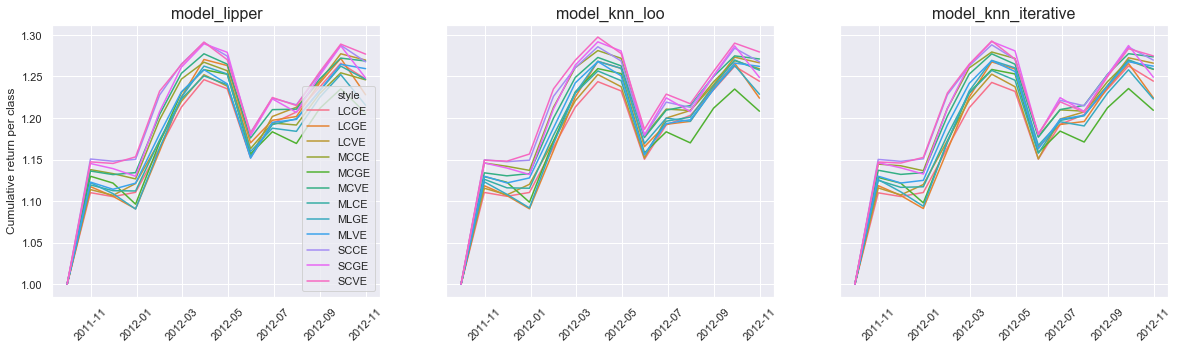

In [150]:
fig, ax = plt.subplots(figsize=(20,5),ncols=3, sharey='row')
for i, col in enumerate(cols):
    sns.lineplot(data = style_returns.query(''' model == @col '''),
                 x='report_dt', y='cum_ret', hue='style', ax=ax[i])

# Subplot titles
title = cols
ax[0].set_ylabel('Cumulative return per class')

for i in range(0,3):
    ax[i].set_title(title[i], fontsize = 16)
    ax[i].set_xlabel('')
    for label in ax[i].get_xticklabels():
        label.set_rotation(45)
        
for i in range(1,3):
    ax[i].get_legend().remove()

plt.show()

## Sanity checks

### Analysing individual portfolios

In [ ]:
comparing_df.query('''true == 'V' and iterative_5 == 'G' ''').head()

In [ ]:
crsp_fundno = 18307
most_common_stocks_fund(year=2017, crsp_fundno=crsp_fundno)

In [ ]:
def most_common_stocks_fund(crsp_fundno,row_info,year):
    "This prints a passed string into this function"
    # Enter date for which most common holdings are calculated
    year = year
    crsp_fundno = crsp_fundno
    row_info_l = row_info

    holdings_coo = holdings.tocoo()

    df_sparse = pd.DataFrame({'row'  : holdings_coo.row,
                              'col'  : holdings_coo.col,
                              'data' : holdings_coo.data})

    df_sparse = df_sparse.merge(row_info_l[['year','row','crsp_fundno']],how='left',on='row')
    my_filter = '''year == @year and crsp_fundno == @crsp_fundno '''
    no_unique_funds = row_info_l.query(my_filter).shape[0]

    sum_col = (df_sparse
               .query(my_filter)
               .groupby(by = ['col'])
               .mean()
               .sort_values('data',ascending = False)
               .join(col_info[['security_name','col']],how='left')
               .assign(percent = lambda x:  x.data)
               .drop(columns=['row','data','col','year','crsp_fundno'])
               .reset_index(drop=True)
               .head(10))
    
    print(
        'Average of most held stocks for one fund in one year: ','\n\n'
        '{}'.format(row_info.query('crsp_fundno == @crsp_fundno').iloc[0,2]),'\n\n'
        'crsp_fundno:                            {}'.format(crsp_fundno),'\n'
        'Number of observations in that year:    {}'.format(no_unique_funds))

    return sum_col

### Inspecting individual nearest neighbors

In [ ]:
neigh.kneighbors(X[1234],n_neighbors = n_neighbors)

In [ ]:
def name_nearestneighbors(row_info,neigh,i,n_neighbors = 5):
    print('Name:')
    print(row_info.loc[i].fund_name)
    print(row_info.loc[i].crsp_fundno)
    print('\nNearest Neighbors:')
    nn_index = neigh.kneighbors(X[i],n_neighbors = n_neighbors)[1].flatten()
    nn_names = row_info.loc[nn_index].fund_name.values
    nn_fundno = row_info.loc[nn_index].crsp_fundno.values
    
    for name in nn_names[1:]:
        print(name)

In [ ]:
name_nearestneighbors(row_info,neigh,i = 1234, n_neighbors = 5)

In [ ]:
crsp_fundno = 36608
most_common_stocks_fund(crsp_fundno=crsp_fundno)

In [ ]:
crsp_fundno = 3690
most_common_stocks_fund(crsp_fundno=crsp_fundno)

### Tests

In [ ]:
row_info_m = row_info_f.copy()
returns_m = returns_f.copy()

In [ ]:
# concat predicted styles to row_info
row_info_m = pd.concat([row_info_m,style_df],axis = 1)

In [ ]:
# merge predicted styles onto returns
returns_m = returns_m.merge(row_info_m[[
                                'crsp_fundno', 'report_dt', 'model_lipper', 'model_knn_full',
                                'model_knn_iterative'
                                ]],
                                how='left',
                                on=['crsp_fundno', 'report_dt'])

In [ ]:
row_info_m.shape

In [ ]:
count = returns_m.groupby(['crsp_fundno']).count()['report_dt']

count.value_counts()

count.sort_values().head(40)

In [ ]:
row_info_m.query('''  crsp_fundno == 29626 ''')

In [ ]:
# melt the different style columns per model into one (from wide to long)
returns_m = pd.melt(returns_m,
                               id_vars=['crsp_fundno', 'report_dt', 'mret'],
                               value_vars=cols,
                               var_name='model',
                               value_name='style')

In [ ]:
# Fill all styles and drop nas
temp = (returns_m
                                .groupby(['model','crsp_fundno'])
                                .apply(lambda x: x.fillna(method = 'ffill'))
)

returns_m['style'] = temp['style']

In [ ]:
returns_m.query('''crsp_fundno == 29626''')

In [ ]:
returns_m.shape

In [ ]:
returns_m = returns_m.dropna()

In [ ]:
# Calc mean return per style
style_returns = (returns_m
                                .groupby(['model','style','report_dt'])
                                .mean()
                                .reset_index()
                                .drop(columns='crsp_fundno')
)

In [ ]:
    # Calc cumret per style
    style_returns['cum_ret'] = (style_returns
                                    .assign(cum_ret = lambda x: x.mret + 1)
                                    .groupby(['model','style'])
                                    .apply(lambda x: x['cum_ret'].cumprod())
                                    .reset_index()
                                    ['cum_ret']
    )

In [ ]:
    # Merge style returns onto fund returns and calc tracking error
    returns_m = (returns_m
                                    .rename(columns = {'mret' : 'fund_ret'}) 
                                    .merge(style_returns,
                                                how = 'left',
                                                on = ['model','style','report_dt'])
                                    .assign(error = lambda df: df['fund_ret'] - df['mret'])
                                    .rename(columns = {'mret' : 'style_ret',
                                                       'cum_ret' : 'style_cum'}) 
    )

In [ ]:
    returns_m = returns_m[['crsp_fundno', 'report_dt', 'model', 'style',
                           'fund_ret', 'style_ret', 'style_cum', 'error']]